# Вебинар 5. Ранжирование и Гибридные рекоммендательные системы

# 1. Ранжирование

### 1.1 BPR - Bayesian Personalized Ranking loss

$$loss = \sigma(p^{+} - p^{-})$$

1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p^{+}$, $p^{-}$ --> $p^{+} - p^{-}$
4. loss = $\sigma(p^{+} - p^{-})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

### 1.2 WARP = Weighted Approximate-Rank Pairwise loss
Неплохое [объяснение](https://medium.com/@gabrieltseng/intro-to-warp-loss-automatic-differentiation-and-pytorch-b6aa5083187a) на игрушечном примере

$$loss = ln(\frac{K-1}{N})*(p^- - p^+)$$

1. Сэмплируем случайную позитивную пару юзер-item, прогноз модели для этой пары $p^+$
2. Сюмплируем далее до тех пор, пока не найдем негативную пару, гду прогнозная вероятность вероятность $p^-$ > $p^+$
3. K - кол-во сэмплирований (зависит от качества модели!)
4. N - общее количество рекомендаций

**Note**  
loss зависит только от 2ух сэмплированных пар, эмбеддинги только ждя этих пар будут обновлены

In [1]:
# Case 1
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 4.5

print(f'loss(random_seed) = {[(3-1) / 10 * (4.5 - 4.3)]}')

# Case 2 -  модель лучше в этом случае
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 0.5
p_neg_3 = -0.5
p_neg_4 = 2.1
p_neg_5 = 4.5

print(f'loss(random_seed) = {[(6-1) / 10 * (4.5 - 4.3)]}')

loss(random_seed) = [0.040000000000000036]
loss(random_seed) = [0.10000000000000009]


### Зачем нужно ранжирование? Есть же классификация (предсказание 0 и 1)
- Ранжирование гораздо лучше выбирает топ-k товаров, особенно когда k велико
- Ранжирование позволяет напрямуб ранжировать 5 релевантных юзеру товаров (какой из 5 поставить выше?)

НО:
- При ранжировании невозможно использовать предсказание как вероятность

Прогноз (p) = вероятность  

Мат ож выручки = p * Price

---

# 2. LightFM

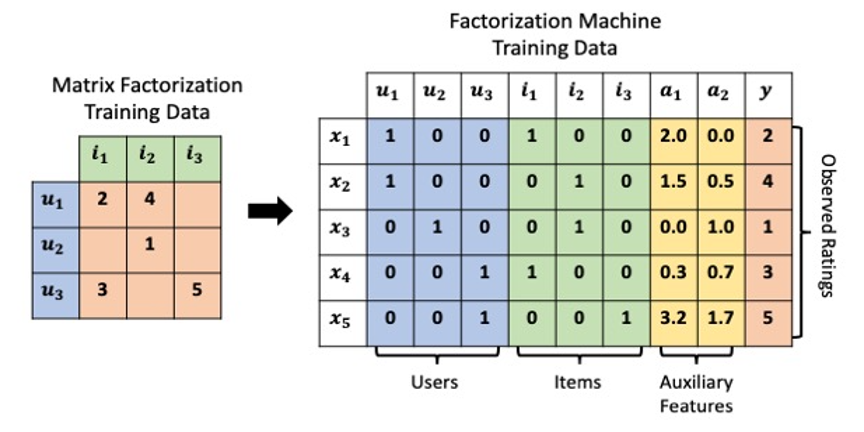

Формула эмбеддинга в ALS (матричной факторизации)

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

Формула в LightFM

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n + \alpha_1 * f_1 + ... + \alpha_k * f_k$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

### Зачем нужны гибридные системы?

*Холодный старт* - ситуация, в которой с товаром/юзером в матрице мало взаимодействий

Холодный страт для товаров - обычно введение нового товара (YouTube, Lamoda, hh.ru)  
Холодный старт для юзера - к нам пришел новый юзер  

Холодного юзера/товар можно описать фичами --> мы больше о нем знаем --> он уже не такой холодный

In [2]:
# !pip install lightfm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items

In [5]:
data = pd.read_csv('./data/retail_train.csv')
item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [7]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [8]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [9]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [10]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

## 1. Filter items

In [12]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train, item_features=item_features)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


## 2. Prepare data set

In [13]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
# data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,117847,818981,819255,819308,819400,819487,819590,819594,819840,819845,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [15]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [16]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [18]:
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
model = LightFM(no_components=30,
                loss='bpr', # 'warp'
                learning_rate=0.05, 
                item_alpha=0.1, user_alpha=0.1, 
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4) 

In [41]:
model.

{'loss': 'bpr',
 'learning_schedule': 'adagrad',
 'no_components': 30,
 'learning_rate': 0.05,
 'k': 5,
 'n': 10,
 'rho': 0.95,
 'epsilon': 1e-06,
 'max_sampled': 10,
 'item_alpha': 0.1,
 'user_alpha': 0.1,
 'random_state': RandomState(MT19937) at 0x7F9E9FB5F440}

In [20]:
user_emb = model.get_user_representations(features=csr_matrix(user_feat_lightfm.values).tocsr())

In [28]:
user_emb[0]  # biases

array([-55.938877,   0.      ,   0.      , ..., -57.58276 , -41.927647,
         0.      ], dtype=float32)

In [29]:
user_emb[0].shape

(2497,)

In [30]:
user_emb[1]  # embeddings

array([[-0.00465083,  0.00057994, -0.00187398, ..., -0.00173732,
        -0.00118214,  0.00198248],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.0050117 , -0.00030614, -0.00162728, ...,  0.00186743,
         0.00077936,  0.00339684],
       [ 0.00222416, -0.00058809,  0.00711343, ...,  0.00560092,
        -0.00249064,  0.00560834],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [31]:
user_emb[1].shape

(2497, 30)

In [32]:
item_emb = model.get_item_representations(features=csr_matrix(item_feat_lightfm.values).tocsr())

In [33]:
item_emb[0].shape

(5001,)

In [34]:
item_emb[1].shape

(5001, 30)

In [35]:
train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

0.21169405

In [36]:
test_item_ids = np.array([1, 2, 3, 200, 1200])

predictions = model.predict(user_ids=0, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=4)

In [37]:
predictions

array([-80.76826 , -80.84887 , -80.36748 , -80.226456, -80.605835],
      dtype=float32)

predictions - некоторые числа. 

### Сравнение различных функций потерь

In [39]:
# Code

### Построение зависимости метрики от K

In [ ]:
# Code